### **Escolha do Problema**
**Objetivo do Trabalho**  
O objetivo principal deste projeto é prever o preço (`Price`) de imóveis em Portugal com base nas suas características. O preço é uma variável contínua, o que torna a tarefa de regressão a abordagem mais adequada.

**Regressão:**
1. **Natureza da Variável Alvo**:
   - A variável `Price` é numérica e contínua.
   - Como a previsão precisa fornecer valores numéricos em um intervalo amplo, a regressão é a abordagem ideal.

2. **Exploração de Fatores Determinantes**:
   - A regressão permite avaliar como as variáveis explicativas (ex.: localização, número de quartos, área construída) afetam o preço de forma quantitativa.
   - Isso contribui para a interpretação prática dos resultados, como "Quanto aumenta o valor por metro quadrado adicional?".

### Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [16]:
df = pd.read_csv('portugal_listinigs.csv')
df.head()

/var/folders/vl/y_41x5_50d55msx55mh9_lk00000gn/T/ipykernel_92955/1044130243.py:1: DtypeWarning: Columns (6,8,12,13,14,15,16,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('portugal_listinigs.csv')


,Price,District,City,Town,Type,EnergyCertificate,Floor,Parking,HasParking,ConstructionYear,...,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms
0,250000.0,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,2nd Floor,1.0,True,NaN,...,True,NaN,2.0,NaN,NaN,NaN,114.0,NaN,NaN,2.0
1,9500.0,Faro,Albufeira,Albufeira e Olhos de Água,Apartment,NC,1st Floor,0.0,False,1990.0,...,True,NaN,0.0,NaN,NaN,NaN,27.0,NaN,NaN,1.0
2,580000.0,Faro,Vila do Bispo,Budens,Apartment,D,3rd Floor,1.0,True,2003.0,...,False,NaN,2.0,NaN,NaN,NaN,84.0,NaN,NaN,2.0
3,350000.0,Faro,Portimão,Portimão,Apartment,C,4th Floor,0.0,False,1985.0,...,True,NaN,2.0,NaN,NaN,NaN,68.0,NaN,NaN,1.0
4,175000.0,Faro,Faro,Faro (Sé e São Pedro),House,NC,NaN,0.0,False,1950.0,...,False,NaN,4.0,NaN,NaN,NaN,78.0,NaN,NaN,2.0


In [17]:
print("Informações do Dataset:")
print(df.info())

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120826 entries, 0 to 120825
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Price                  120545 non-null  float64
 1   District               120826 non-null  object 
 2   City                   120826 non-null  object 
 3   Town                   120824 non-null  object 
 4   Type                   120810 non-null  object 
 5   EnergyCertificate      120812 non-null  object 
 6   Floor                  27929 non-null   object 
 7   Parking                120632 non-null  float64
 8   HasParking             68215 non-null   object 
 9   ConstructionYear       78228 non-null   float64
 10  TotalArea              113782 non-null  float64
 11  GrossArea              27638 non-null   float64
 12  EnergyEfficiencyLevel  52579 non-null   object 
 13  PublishDate            19224 non-null   object 
 14  Garage      

In [18]:
print("\nValores ausentes por coluna:")
print(df.isnull().sum())


Valores ausentes por coluna:
Price                       281
District                      0
City                          0
Town                          2
Type                         16
EnergyCertificate            14
Floor                     92897
Parking                     194
HasParking                52611
ConstructionYear          42598
TotalArea                  7044
GrossArea                 93188
EnergyEfficiencyLevel     68247
PublishDate              101602
Garage                    68247
Elevator                     32
ElectricCarsCharging      68247
TotalRooms                53024
NumberOfBedrooms          85398
NumberOfWC                74205
ConservationStatus       105784
LivingArea                28297
LotSize                   88736
BuiltArea                 99849
NumberOfBathrooms          5730
dtype: int64


In [19]:
print("\nDuplicados:", df.duplicated().sum())


Duplicados: 6941


#### Distribuição da variável alvo (Price)

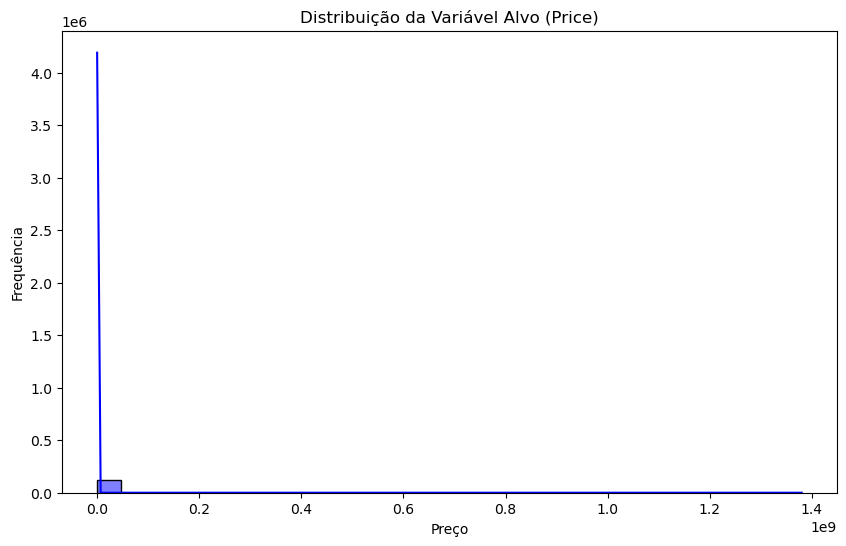

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True, bins=30, color='blue')
plt.title('Distribuição da Variável Alvo (Price)')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.show()

#### Distribuição dos Distritos

/var/folders/vl/y_41x5_50d55msx55mh9_lk00000gn/T/ipykernel_92955/1659761120.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='District', data=df, order=df['District'].value_counts().index, palette='viridis')


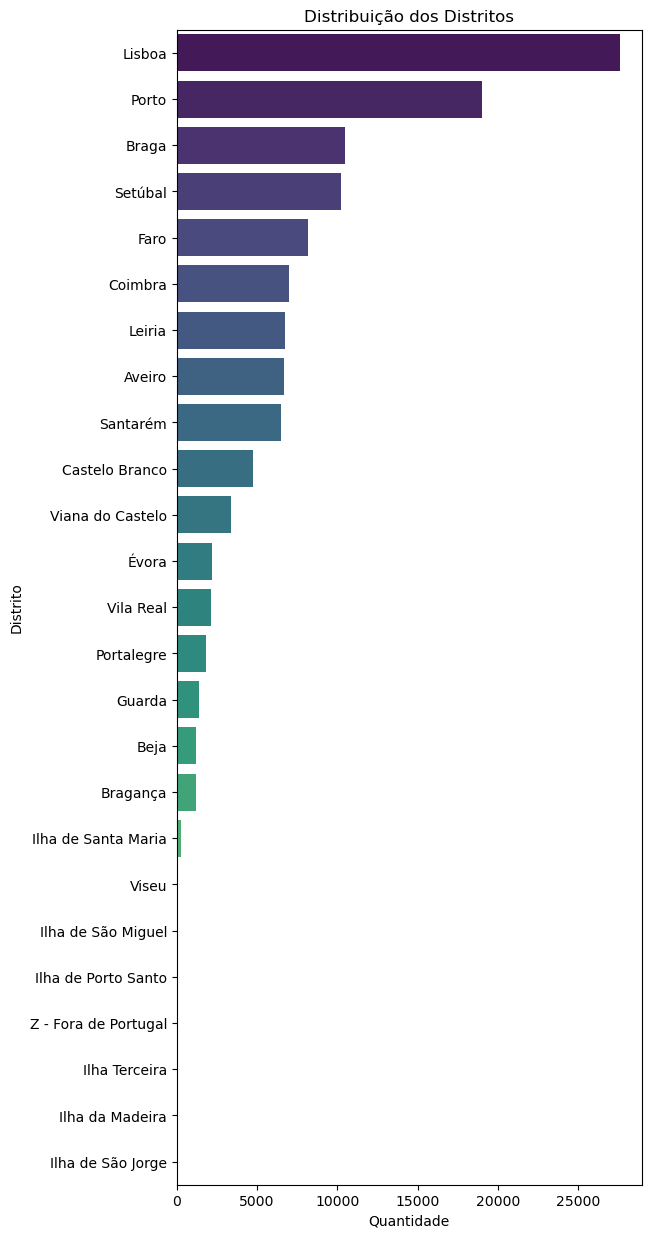

In [26]:
plt.figure(figsize=(6, 15))
sns.countplot(y='District', data=df, order=df['District'].value_counts().index, palette='viridis')
plt.title('Distribuição dos Distritos')
plt.xlabel('Quantidade')
plt.ylabel('Distrito')
plt.show()

#### Distribuição das Cidades

/var/folders/vl/y_41x5_50d55msx55mh9_lk00000gn/T/ipykernel_92955/455381550.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='City', data=df, order=df['City'].value_counts().index, palette='viridis')


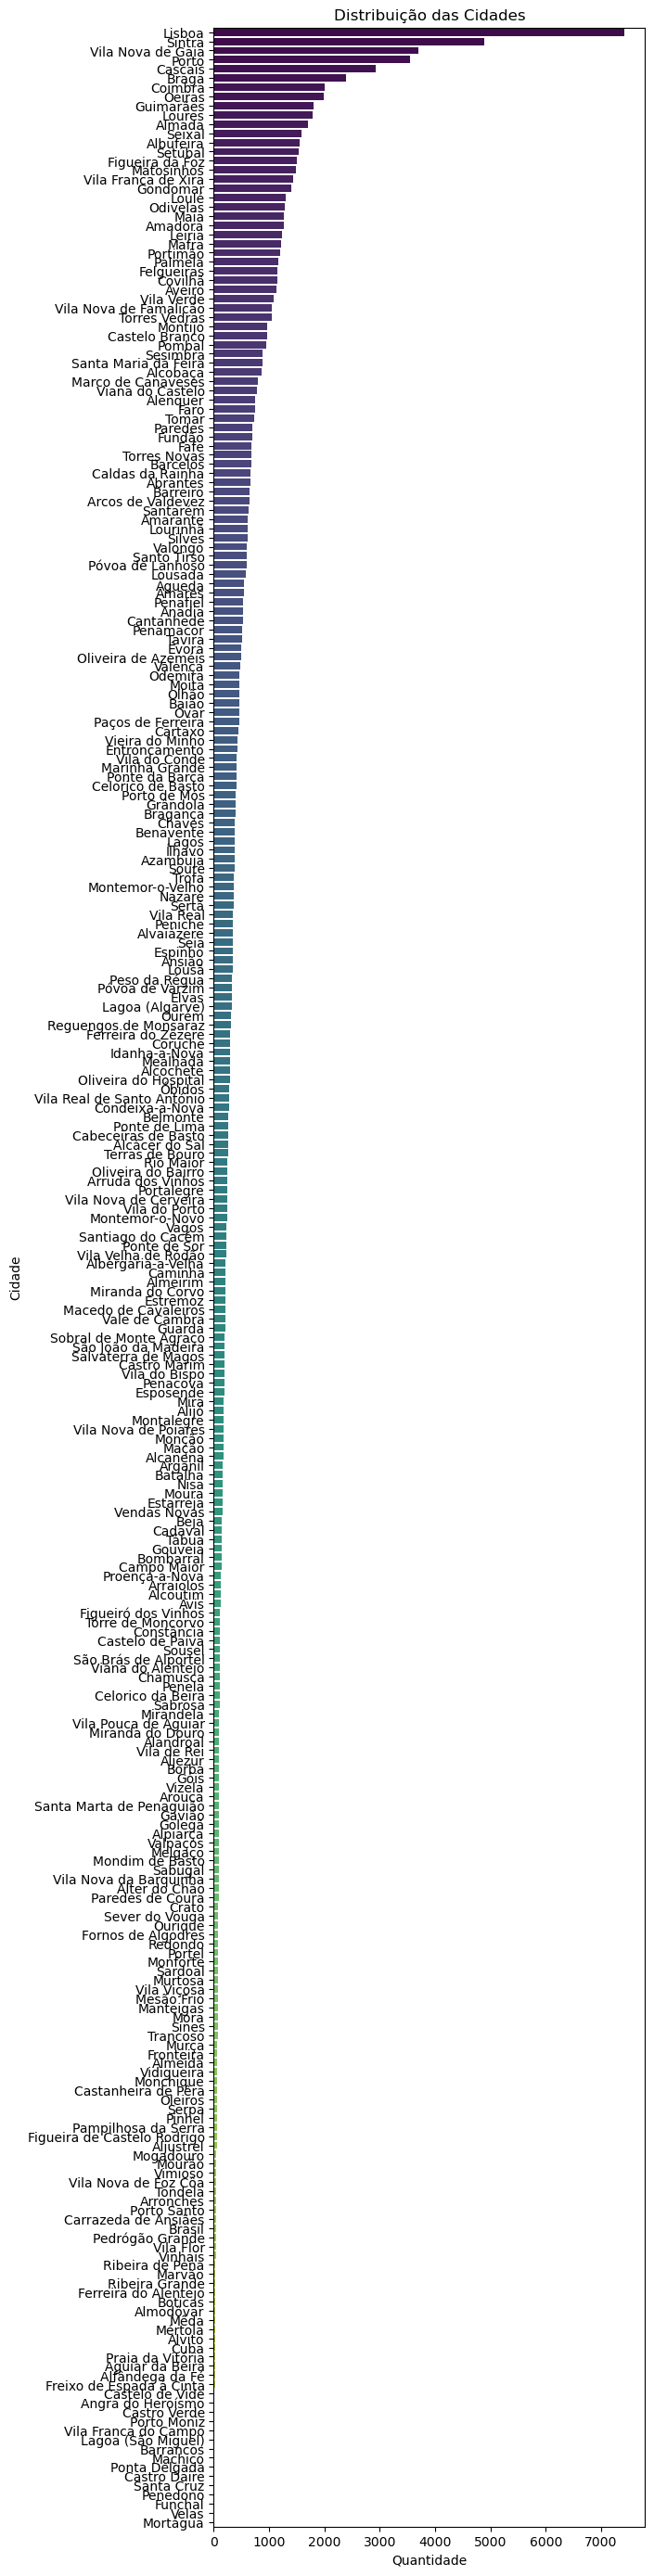

In [39]:
plt.figure(figsize=(6, 35))
sns.countplot(y='City', data=df, order=df['City'].value_counts().index, palette='viridis')
plt.title('Distribuição das Cidades')
plt.xlabel('Quantidade')
plt.ylabel('Cidade')
plt.show()

#### Distribuição do Tipo

/var/folders/vl/y_41x5_50d55msx55mh9_lk00000gn/T/ipykernel_92955/3780347777.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Type', data=df, order=df['Type'].value_counts().index, palette='viridis')


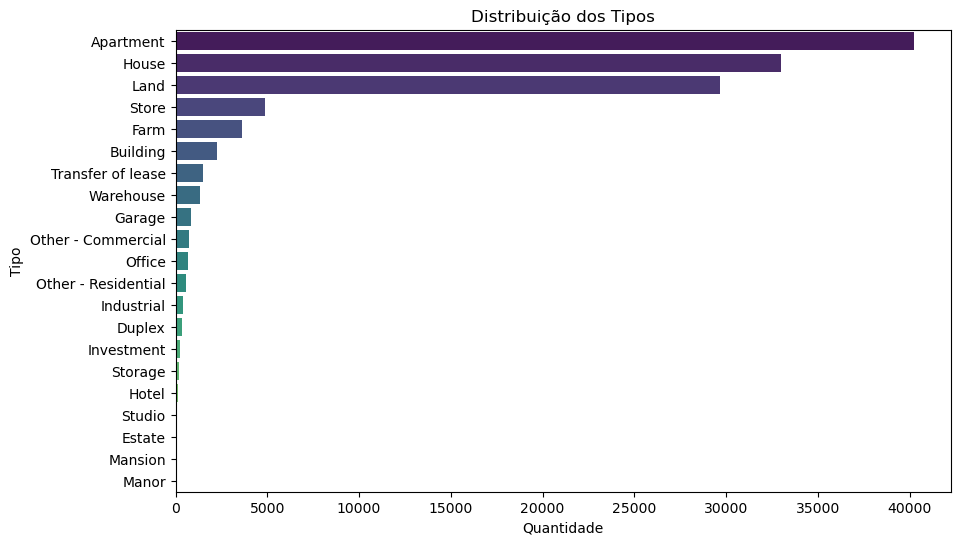

In [44]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Type', data=df, order=df['Type'].value_counts().index, palette='viridis')
plt.title('Distribuição dos Tipos')
plt.xlabel('Quantidade')
plt.ylabel('Tipo')
plt.show()

#### Distribuição do Certificado de Energia

/var/folders/vl/y_41x5_50d55msx55mh9_lk00000gn/T/ipykernel_92955/2905392872.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='EnergyCertificate', data=df, order=df['EnergyCertificate'].value_counts().index, palette='viridis')


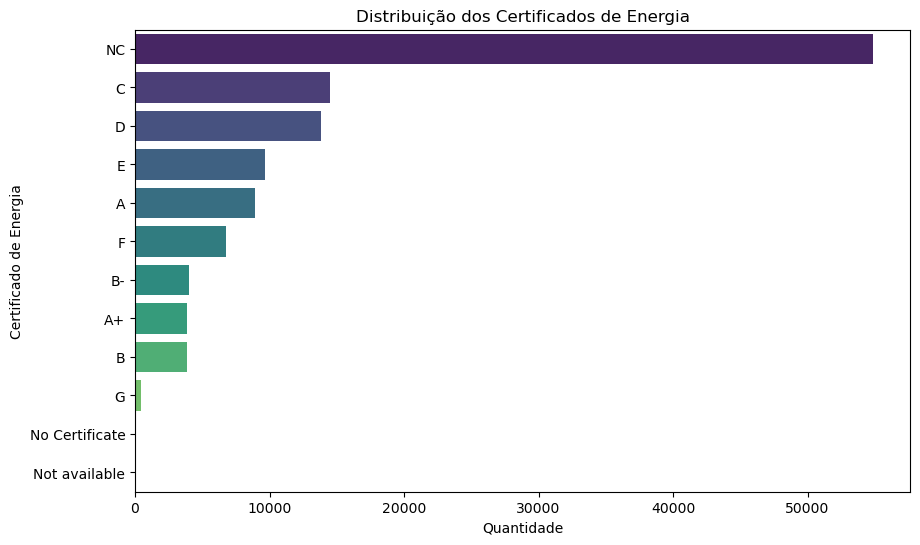

In [46]:
plt.figure(figsize=(10, 6))
sns.countplot(y='EnergyCertificate', data=df, order=df['EnergyCertificate'].value_counts().index, palette='viridis')
plt.title('Distribuição dos Certificados de Energia')
plt.xlabel('Quantidade')
plt.ylabel('Certificado de Energia')
plt.show()

#### Distribuição dos Andares

/var/folders/vl/y_41x5_50d55msx55mh9_lk00000gn/T/ipykernel_92955/764607028.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Floor', data=df, order=df['Floor'].value_counts().index, palette='viridis')


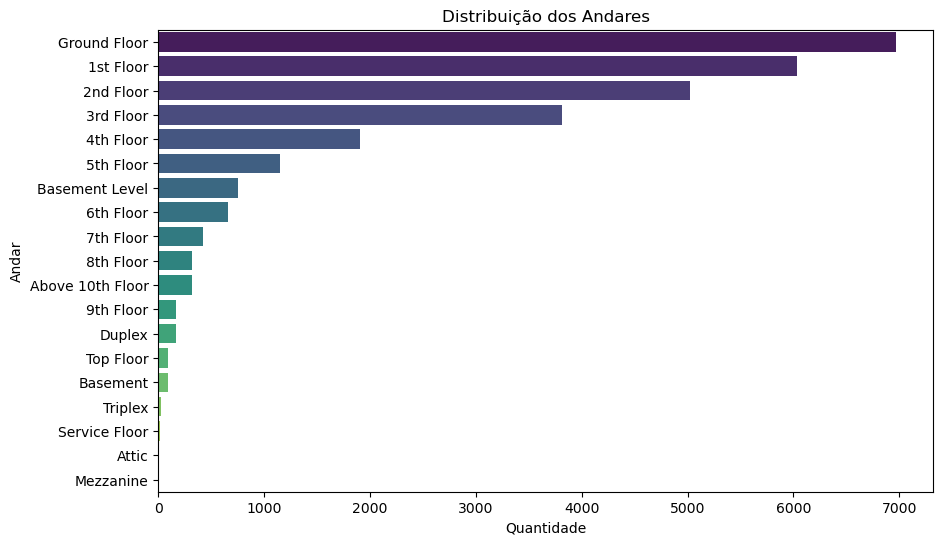

In [47]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Floor', data=df, order=df['Floor'].value_counts().index, palette='viridis')
plt.title('Distribuição dos Andares')
plt.xlabel('Quantidade')
plt.ylabel('Andar')
plt.show()

#### Distribuição dos Elevadores

/var/folders/vl/y_41x5_50d55msx55mh9_lk00000gn/T/ipykernel_92955/3972428279.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Elevator', data=df, order=df['Elevator'].value_counts().index, palette='viridis')


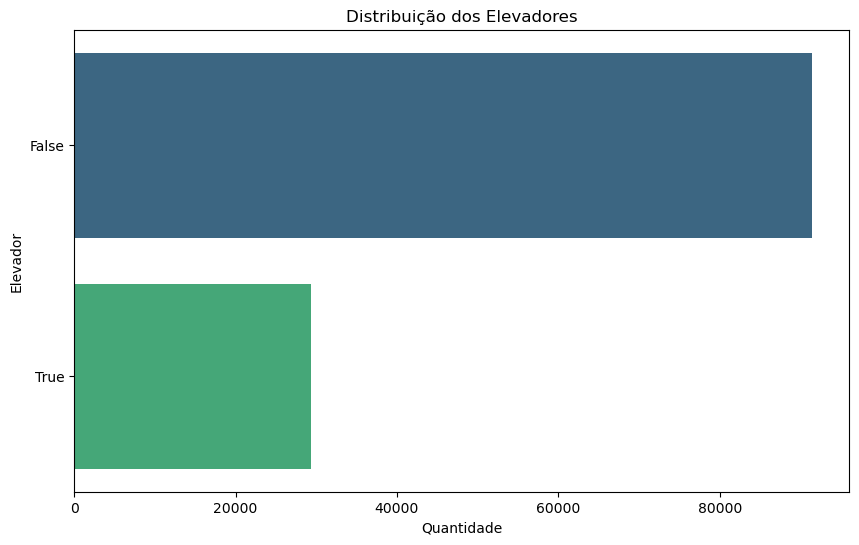

In [48]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Elevator', data=df, order=df['Elevator'].value_counts().index, palette='viridis')
plt.title('Distribuição dos Elevadores')
plt.xlabel('Quantidade')
plt.ylabel('Elevador')
plt.show()